## Imports

In [1]:
import os
import shutil
import tempfile
import json

import matplotlib.pyplot as plt

from monai.inferers import sliding_window_inference
from monai.config import print_config
from sklearn.model_selection import KFold

import torch
#import pytorch_lightning
import lightning
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from monai_unet_cv import Net


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)
torch.backends.cudnn.benchmark = True

device =  cuda


In [3]:
PATH = "E:\\Visual Studio\\Task01_BrainTumour\\"
K_FOLDS = 5

## Run the training

In [4]:
torch.set_float32_matmul_precision('medium')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
with open(PATH + "dataset.json", 'r') as f:
    data = json.load(f)

test_size = int(0.1 * len(data["training"]))
for i,  entry in enumerate(data["training"]):
        entry['image'] = os.path.abspath(os.path.join(PATH, entry['image']))
        entry['label'] = os.path.abspath(os.path.join(PATH, entry['label']))
test_data = data["training"][:test_size]
train_val_data = data["training"][test_size:]
kf = KFold(n_splits=K_FOLDS)
for i, (train_index, val_index) in enumerate(kf.split(train_val_data), 1):
    data['training'] = [train_val_data[idx] for idx in train_index]
    data['validation'] = [train_val_data[idx] for idx in val_index]
    data['test'] = test_data

    # initialise the LightningModule
    net = Net(device=device, data=data, in_channels=4, out_channels=4, augmentation=False)

    # set up checkpoints
    # TODO model callback set when val_loss lowest
    checkpoint_callback = ModelCheckpoint(dirpath="./heart_data_lightning_models/", filename='{epoch}-{val_loss:.2f}-{val_dice:.2f}', monitor="val_dice", mode="max")
    early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    max_epochs = 3

    # initialise Lightning's trainer.
    trainer = lightning.Trainer(
        devices=[0],
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=4,
    )

    # train
    trainer.fit(net)

    # TODO add plot of each fold validation metric

[{'image': './imagesTr/BRATS_457.nii.gz', 'label': './labelsTr/BRATS_457.nii.gz'}, {'image': './imagesTr/BRATS_306.nii.gz', 'label': './labelsTr/BRATS_306.nii.gz'}, {'image': './imagesTr/BRATS_206.nii.gz', 'label': './labelsTr/BRATS_206.nii.gz'}, {'image': './imagesTr/BRATS_449.nii.gz', 'label': './labelsTr/BRATS_449.nii.gz'}, {'image': './imagesTr/BRATS_318.nii.gz', 'label': './labelsTr/BRATS_318.nii.gz'}, {'image': './imagesTr/BRATS_218.nii.gz', 'label': './labelsTr/BRATS_218.nii.gz'}, {'image': './imagesTr/BRATS_434.nii.gz', 'label': './labelsTr/BRATS_434.nii.gz'}, {'image': './imagesTr/BRATS_365.nii.gz', 'label': './labelsTr/BRATS_365.nii.gz'}, {'image': './imagesTr/BRATS_265.nii.gz', 'label': './labelsTr/BRATS_265.nii.gz'}, {'image': './imagesTr/BRATS_214.nii.gz', 'label': './labelsTr/BRATS_214.nii.gz'}, {'image': './imagesTr/BRATS_314.nii.gz', 'label': './labelsTr/BRATS_314.nii.gz'}, {'image': './imagesTr/BRATS_445.nii.gz', 'label': './labelsTr/BRATS_445.nii.gz'}, {'image': './im

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
g:\Anaconda\install\envs\D7043EProject\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
g:\Anaconda\install\envs\D7043EProject\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]current epoch: 0 current val_loss: 36.54347610473633 current mean dice: 0.0153
best mean dice: 0.0153 at epoch: 0
Epoch 0: 100%|██████████| 348/348 [01:39<00:00,  3.50it/s, v_num=33]       current epoch: 0 current val_loss: 1.1700379848480225 current mean dice: 0.0634
best mean dice: 0.0634 at epoch: 0
Epoch 1: 100%|██████████| 348/348 [00:19<00:00, 17.80it/s, v_num=33]current epoch: 1 current val_loss: 0.9952369928359985 current mean dice: 0.1385
best mean dice: 0.1385 at epoch: 1
Epoch 2: 100%|██████████| 348/348 [00:19<00:00, 17.75it/s, v_num=33]current epoch: 2 current val_loss: 0.800383985042572 current mean dice: 0.1853
best mean dice: 0.1853 at epoch: 2
Epoch 2: 100%|██████████| 348/348 [00:22<00:00, 15.73it/s, v_num=33]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 348/348 [00:22<00:00, 15.38it/s, v_num=33]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNet       | 4.8 M 
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.254    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]current epoch: 0 current val_loss: 67.84092712402344 current mean dice: 0.0052
best mean dice: 0.0052 at epoch: 0
Epoch 0: 100%|██████████| 349/349 [01:11<00:00,  4.86it/s, v_num=34]       current epoch: 0 current val_loss: 1.171341061592102 current mean dice: 0.0157
best mean dice: 0.0157 at epoch: 0
Epoch 1: 100%|██████████| 349/349 [00:19<00:00, 17.81it/s, v_num=34]current epoch: 1 current val_loss: 0.8997746109962463 current mean dice: 0.0216
best mean dice: 0.0216 at epoch: 1
Epoch 2: 100%|██████████| 349/349 [00:19<00:00, 17.74it/s, v_num=34]current epoch: 2 current val_loss: 0.840735912322998 current mean dice: 0.1156
best mean dice: 0.1156 at epoch: 2
Epoch 2: 100%|██████████| 349/349 [00:22<00:00, 15.69it/s, v_num=34]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 349/349 [00:22<00:00, 15.36it/s, v_num=34]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNet       | 4.8 M 
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.254    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]current epoch: 0 current val_loss: 42.82264709472656 current mean dice: 0.0092
best mean dice: 0.0092 at epoch: 0
Epoch 0: 100%|██████████| 349/349 [01:16<00:00,  4.58it/s, v_num=35]       current epoch: 0 current val_loss: 1.2776250839233398 current mean dice: 0.0053
best mean dice: 0.0092 at epoch: 0
Epoch 1: 100%|██████████| 349/349 [00:20<00:00, 17.23it/s, v_num=35]current epoch: 1 current val_loss: 0.9635024666786194 current mean dice: 0.1542
best mean dice: 0.1542 at epoch: 1
Epoch 2: 100%|██████████| 349/349 [00:20<00:00, 16.78it/s, v_num=35]current epoch: 2 current val_loss: 0.8227338194847107 current mean dice: 0.1676
best mean dice: 0.1676 at epoch: 2
Epoch 2: 100%|██████████| 349/349 [00:23<00:00, 14.92it/s, v_num=35]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 349/349 [00:23<00:00, 14.62it/s, v_num=35]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 48/48 [00:52<00:00,  1.10s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNet       | 4.8 M 
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.254    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]current epoch: 0 current val_loss: 70.9260025024414 current mean dice: 0.0194
best mean dice: 0.0194 at epoch: 0
Epoch 0: 100%|██████████| 349/349 [01:12<00:00,  4.81it/s, v_num=36]       current epoch: 0 current val_loss: 1.1422797441482544 current mean dice: 0.0199
best mean dice: 0.0199 at epoch: 0
Epoch 1: 100%|██████████| 349/349 [00:20<00:00, 17.23it/s, v_num=36]current epoch: 1 current val_loss: 0.9001780152320862 current mean dice: 0.1021
best mean dice: 0.1021 at epoch: 1
Epoch 2: 100%|██████████| 349/349 [00:20<00:00, 17.33it/s, v_num=36]current epoch: 2 current val_loss: 0.8160330057144165 current mean dice: 0.1075
best mean dice: 0.1075 at epoch: 2
Epoch 2: 100%|██████████| 349/349 [00:22<00:00, 15.37it/s, v_num=36]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 349/349 [00:23<00:00, 14.99it/s, v_num=36]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 48/48 [00:49<00:00,  1.03s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNet       | 4.8 M 
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.254    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]current epoch: 0 current val_loss: 41.222373962402344 current mean dice: 0.0239
best mean dice: 0.0239 at epoch: 0
Epoch 0: 100%|██████████| 349/349 [01:12<00:00,  4.81it/s, v_num=37]       current epoch: 0 current val_loss: 1.1247029304504395 current mean dice: 0.0232
best mean dice: 0.0239 at epoch: 0
Epoch 1: 100%|██████████| 349/349 [00:19<00:00, 17.52it/s, v_num=37]current epoch: 1 current val_loss: 0.9285627603530884 current mean dice: 0.1426
best mean dice: 0.1426 at epoch: 1
Epoch 2: 100%|██████████| 349/349 [00:19<00:00, 17.61it/s, v_num=37]current epoch: 2 current val_loss: 0.9251927733421326 current mean dice: 0.1606
best mean dice: 0.1606 at epoch: 2
Epoch 2: 100%|██████████| 349/349 [00:22<00:00, 15.56it/s, v_num=37]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 349/349 [00:22<00:00, 15.23it/s, v_num=37]


## Plot the loss and dice metric

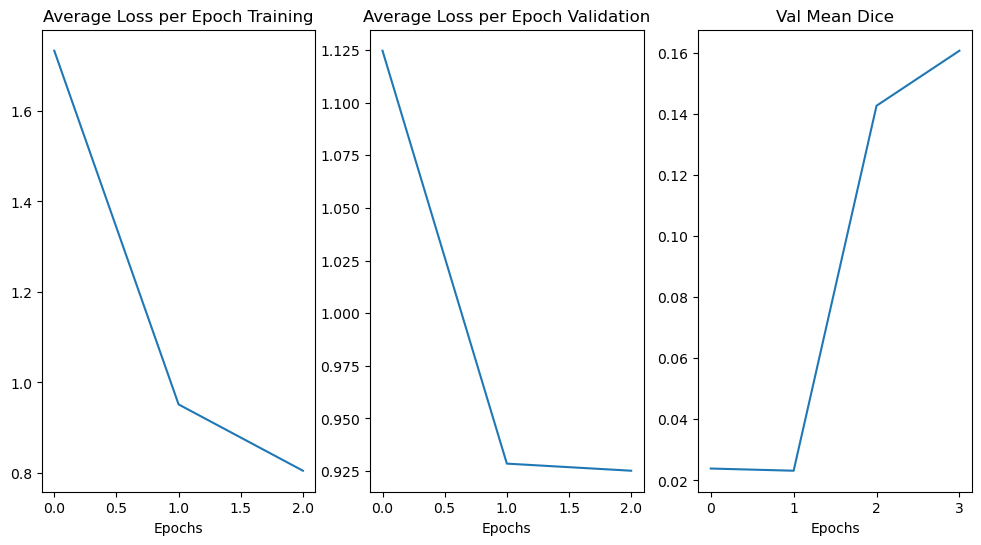

In [7]:
plt.figure("train", (12, 6))
plt.subplot(1, 3, 1)
plt.title("Average Loss per Epoch Training")
x = [i for i in range(0,len(net.epoch_train_loss))]
y = net.epoch_train_loss
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 2)
plt.title("Average Loss per Epoch Validation")
# skip first epoch for validation loss as it is very high
x = [i for i in range(0,len(net.epoch_val_loss)-1)]
y = net.epoch_val_loss[1:]
plt.xlabel("Epochs")
plt.plot(x, y)
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice")
x = [i for i in range(0,len(net.metric_values))]
y = net.metric_values
plt.xlabel("Epochs")
plt.plot(x, y)
plt.show()

## Test model on unseen data

In [8]:
# this will print the avg loss and dice metric on the test set
trainer.test()

g:\Anaconda\install\envs\D7043EProject\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Loading dataset: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]
Restoring states from the checkpoint path at ./heart_data_lightning_models/epoch=2-val_loss=0.93-val_dice=0.16.ckpt
g:\Anaconda\install\envs\D7043EProject\Lib\site-packages\lightning\fabric\utilities\cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob

Testing DataLoader 0: 100%|██████████| 48/48 [00:01<00:00, 34.78it/s]


[{}]

## Load model from checkpoint to plot predictions

In [9]:
model = Net.load_from_checkpoint(checkpoint_callback.best_model_path, device = device, in_channels=4, out_channels=4, augmentation=False, datadir = PATH)
model.eval()
model.to(device)
model.prepare_data()

TypeError: Net.__init__() missing 1 required positional argument: 'data'

In [ ]:
# make predictions
images = []
outputs = []
labels = []
val_loader = model.test_dataloader()
#TODO only make predictions for some images?
i = 0
for val_data in val_loader: 
    if i ==2:
        break
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )
    images.append(val_inputs)
    outputs.append(model.forward(val_inputs))
    labels.append(val_labels)
    i += 1

In [ ]:
def plot_predictions(idx_of_image, outputs, images, labels):
    # Assuming outputs, labels, and images are your variables
    output = outputs[idx_of_image]
    label = labels[idx_of_image][0][0]
    image = images[idx_of_image][0][0]

    # Set the slice range from 45 to 50
    slice_start = 45
    slice_end = 55

    # Calculate the number of slices
    num_slices = slice_end - slice_start

    # Create a subplot with 'num_slices' rows and 3 columns
    plt.figure(figsize=(15, 5 * num_slices))

    for i in range(num_slices):
        # Increment the slice index
        current_slice = slice_start + i
        
        # Plot the Model Output
        plt.subplot(num_slices, 3, 3 * i + 1)
        with torch.no_grad():
            plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
        plt.title(f'Model Output - Slice {current_slice}')

        # Plot the Label
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.imshow(label.cpu()[:, :, current_slice])
        plt.title(f'Label - Slice {current_slice}')

        # Plot the Input Image
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.imshow(image.cpu()[:, :, current_slice])
        plt.title(f'Input Image - Slice {current_slice}')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

## Plot predictions

In [ ]:
plot_predictions(0, outputs, images, labels)